In [1]:
from qite import *
from helper import *
%matplotlib inline
import matplotlib.pyplot as plt

from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere

unit_sim = Aer.get_backend('unitary_simulator')

def get_matrix(qc):
    job = execute(qc, unit_sim)
    result = job.result()
    return np.asarray(result.get_unitary(qc))

def cull(a):
    b = np.where(np.abs(a) < 1e-5, 0, a)
    r = np.where( np.abs(np.real(b)) < 1e-5, 0, np.real(b) )
    i = np.where( np.abs(np.imag(b)) < 1e-5, 0, np.imag(b) )
    return r + 1j*i

In [49]:
qc = QuantumCircuit(4,4)
qbits = [0,1,2,3]
cbits = [0,1,2,3]

# just to see which one is qbit 3:
# qc.h(1)
# qc.rx(np.pi/2,2)
# qc.x(3)

idx = 1*0 + 4*1 + 16*2 + 64*3 # (Measure I0 X1 Y2 Z3)

backend = sv_sim
num_shots = 1000

def meaure_mult(qc, idx, qbits, cbits, backend, num_shots=1024):
    nbits = len(qbits)
    ids = int_to_base4(idx, nbits)

    measures = []

    for i in range(nbits):
        if ids[-(i+1)] == 0:
            # I only has +1 eigenvalues, so the measurement is +1
            continue
        elif ids[-(i+1)] == 1:
            # Rotate to X-basis
            qc.h(qbits[i])
        elif ids[-(i+1)] == 2:
            # Rotate to Y-basis
            qc.rx(-np.pi/2, qbits[i])
        elif ids[-(i+1)] == 3:
            # Already in Z-basis
            None
        else:
            raise ValueError('Only 0,1,2,3 are valid idx')
        measures.append( [qbits[i],cbits[i]] )

    print(measures)
    # Add measurements to the circuit
    for m in measures:
        qc.measure(m[0],m[1])

    # Get the measurement statistics
    counts = run_circuit(qc, backend, num_shots=num_shots)

    expectation = 0
    for key in counts.keys():
        k = key.replace(' ','')
        sign = 1
        print('key: ', k)
        for m in measures:
            if k[-(m[1] + 1)] == '1':
                sign *= -1
        expectation += sign*counts[key]

    expectation /= num_shots
    return expectation

qc.draw()

[[1, 1], [2, 2], [3, 3]]


q_0: ──────────────────
        ┌───┐    ┌─┐   
q_1: ───┤ H ├────┤M├───
     ┌──┴───┴───┐└╥┘┌─┐
q_2: ┤ Rx(-π/2) ├─╫─┤M├
     └───┬─┬────┘ ║ └╥┘
q_3: ────┤M├──────╫──╫─
         └╥┘      ║  ║ 
c: 4/═════╩═══════╩══╩═
          3       1  2

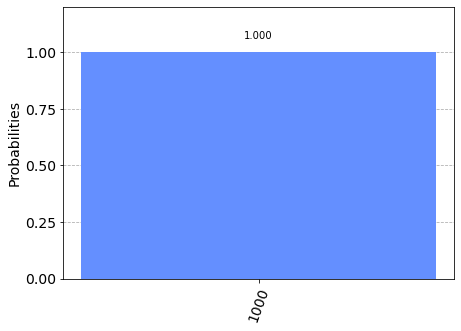

In [47]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [48]:
expectation = 0
for key in counts.keys():
    k = key.replace(' ','')
    sign = 1
    print('key: ', k)
    for m in measures:
        if k[-(m[1] + 1)] == '1':
            sign *= -1
    expectation += sign*counts[key]

expectation /= num_shots
print(expectation)

key:  1000
-1.0
